In [1]:
from pathlib import Path
from tqdm import tqdm
import napari
import tifffile
import numpy as np
from cellpose import models
import skimage
from skimage import measure, exposure
from scipy.ndimage import binary_erosion, binary_dilation, label
import pyclesperanto_prototype as cle
from apoc import ObjectSegmenter, PixelClassifier
import pandas as pd
from utils import count_particles_in_nuclei
import matplotlib.pyplot as plt

In [2]:
# Define the dataset that you want to analyze below ("microglia" or "astrocyte")
dataset = "microglia"

if dataset == "microglia":
    directory_path = Path("./microglia_data/")
    print(f"The following dataset will be analyzed: {str(directory_path)}")
    
elif dataset == "astrocyte":
    directory_path = Path("./astrocyte_data/")
    print(f"The following dataset will be analyzed: {str(directory_path)}")
else:
    print("Please define an existing dataset")

The following dataset will be analyzed: microglia_data


In [3]:
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.lsm"):
    images.append(str(file_path))
    
images

['microglia_data\\DSB Iba1 101_40X_CA1.lsm',
 'microglia_data\\DSB Iba1 101_40X_CA3.lsm',
 'microglia_data\\DSB Iba1 101_40X_CTX1.lsm',
 'microglia_data\\DSB Iba1 101_40X_CTX2.lsm',
 'microglia_data\\DSB Iba1 101_40X_CTX3.lsm',
 'microglia_data\\DSB Iba1 101_40X_DG.lsm',
 'microglia_data\\DSB Iba1 102_40X_CA1.lsm',
 'microglia_data\\DSB Iba1 102_40X_CA3.lsm',
 'microglia_data\\DSB Iba1 102_40X_CTX1.lsm',
 'microglia_data\\DSB Iba1 102_40X_CTX2.lsm',
 'microglia_data\\DSB Iba1 102_40X_CTX3.lsm',
 'microglia_data\\DSB Iba1 102_40X_DG.lsm',
 'microglia_data\\DSB Iba1 103_40X_CA1.lsm',
 'microglia_data\\DSB Iba1 103_40X_CA3.lsm',
 'microglia_data\\DSB Iba1 103_40X_CTX1.lsm',
 'microglia_data\\DSB Iba1 103_40X_CTX2.lsm',
 'microglia_data\\DSB Iba1 103_40X_CTX3.lsm',
 'microglia_data\\DSB Iba1 103_40X_DG.lsm',
 'microglia_data\\DSB Iba1 104_40X_CA1.lsm',
 'microglia_data\\DSB Iba1 104_40X_CA3.lsm',
 'microglia_data\\DSB Iba1 104_40X_CTX1.lsm',
 'microglia_data\\DSB Iba1 104_40X_CTX2.lsm',
 '

In [4]:
# Define analysis parameters
cellpose_nuclei_diameter = 30 # (cellpdia) in the results.csv file 
gaussian_sigma = 1 # (sigma) in the results.csv file
dilation_radius_nuclei = 4 # (dilrad) in the results.csv file
glia_channel_threshold = 20 # (gliathr) in the results.csv file
glia_segmenter = False # If True (glia_sem_seg_v) appears in the results.csv file instead of gliathr
glia_segmenter_version = 1 # (glia_sem_seg_v) in the results.csv file 
glia_nuclei_colocalization_erosion = 6 # (gliaero) in the results.csv file 
dna_damage_segmenter_version = 2 # (dnad_obj_seg_v) in the results.csv file
dna_damage_erosion = 2 # (dnadero) in the results.csv file

# Image index to explore
index = 27

Visualize image and segmentation analysis using Napari

DSB Iba1 105_40X_CTX2


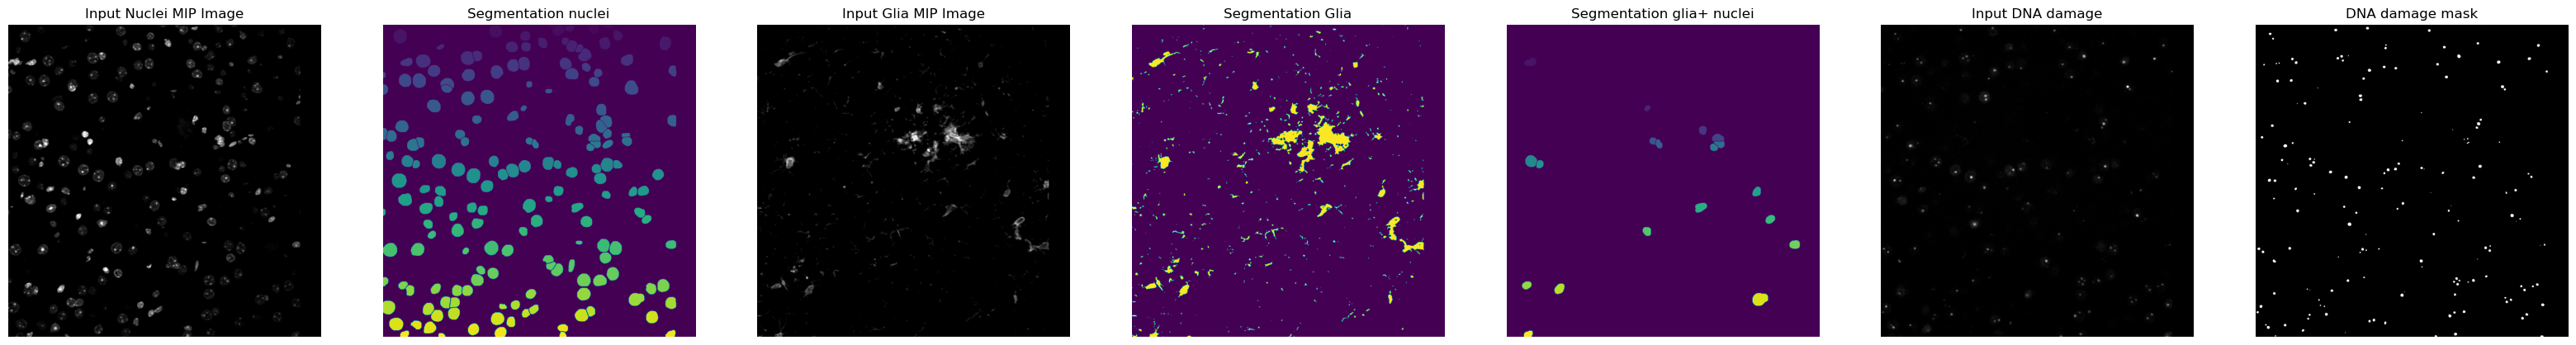

array([2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 3, 1])

In [5]:
viewer = napari.Viewer(ndisplay=2)
model = models.Cellpose(gpu=True, model_type='nuclei')

image = images[index]

# Extract filename
file_path = Path(image)
filename = file_path.stem

# Read the image file 
img = tifffile.imread(image)

# Extract the stack containing the nuclei (0), dna_damage (1) and microglia channel (2)
nuclei_stack = img[:,0,:,:]
dna_damage_stack = img[:,1,:,:]
microglia_stack = img[:,2,:,:]

# Perform maximum intensity projections
nuclei_mip = np.max(nuclei_stack, axis=0)
dna_damage_mip = np.max(dna_damage_stack, axis=0)
microglia_mip = np.max(microglia_stack, axis=0)

# Stack the arrays along a new axis (axis 0)
stack = np.stack((nuclei_mip, dna_damage_mip, microglia_mip), axis=0)

# Create a copy of nuclei_mip
input_img = nuclei_mip.copy()

# Might need to perform a Gaussian-blur before
post_gaussian_img = skimage.filters.gaussian(input_img, sigma=gaussian_sigma)

# Apply Contrast Stretching to improve Cellpose detection of overly bright nuclei
p2, p98 = np.percentile(post_gaussian_img, (2, 98))
img_rescale = exposure.rescale_intensity(post_gaussian_img, in_range=(p2, p98))

# Predict nuclei nuclei_masks using cellpose
nuclei_masks, flows, styles, diams = model.eval(img_rescale, diameter=cellpose_nuclei_diameter, channels=[0, 0], net_avg=False)

# Dilate nuclei to make sure the dna_damage_foci objects sit inside
dilated_nuclei_masks = cle.dilate_labels(nuclei_masks, radius=dilation_radius_nuclei)
# Erode dilated_nuclei_masks to obtain separate objects upon binarization
eroded_nuclei_masks = cle.erode_labels(dilated_nuclei_masks, radius=1)

# Show the resulting stack in Napari
viewer.add_image(stack, name=f"{filename}_mip")
viewer.add_image(nuclei_mip, name=f"{filename}_nuclei")
viewer.add_image(post_gaussian_img, name=f"{filename}_nuclei_gaussian")
viewer.add_image(img_rescale, name=f"{filename}_nuclei_contrast_stretched")
viewer.add_image(nuclei_mip, name=f"{filename}_nuclei")
viewer.add_labels(nuclei_masks, name=f"{filename}_nuclei_mask")
viewer.add_labels(dilated_nuclei_masks, name=f"{filename}_nuclei_mask_dilated")
viewer.add_labels(eroded_nuclei_masks, name=f"{filename}_nuclei_mask_split")

# Set a threshold value for the pixels in microglia channel
threshold = glia_channel_threshold  # Based on the microglia intensity

# Create a new array with the same shape as nuclei_masks, initialized with False
result_array = np.full_like(nuclei_masks, False, dtype=bool)

if glia_segmenter:
        # Predict glia mask using the semantic_segmenter instead of thresholding
        segmenter = PixelClassifier(
        opencl_filename=f"./semantic_segmenters/microglia_segmenter_v{glia_segmenter_version}.cl"
        )
        above_threshold_indices = segmenter.predict(image=microglia_mip)
        # Extract ndarray from OCLArray
        above_threshold_indices = cle.pull(above_threshold_indices)
        # Transform into a boolean array
        above_threshold_indices = above_threshold_indices > 1
else:
        # Find indices where values in values_array are above the threshold
        above_threshold_indices = microglia_mip > threshold

# Display microglia segmentation
viewer.add_labels(above_threshold_indices, name=f"{filename}_glia")

# Update the corresponding positions in the result_array based on the mask_array
nuclei_masks_bool = nuclei_masks.astype(bool) # Make a boolean copy of nuclei_masks to be able to use logical operators
result_array[nuclei_masks_bool & above_threshold_indices] = True

# Convert the boolean array to a binary array
binary_result_array = result_array.astype(int)

# Now, result_array contains True where both conditions are satisfied, and False otherwise
viewer.add_labels(binary_result_array, name=f"{filename}_nuclei+glia_coloc")

# Erode binary_result_array to get rid of small nuclei pixels colocalizing with glia branches
# Set the structuring element for erosion
structuring_element = np.ones((glia_nuclei_colocalization_erosion, glia_nuclei_colocalization_erosion), dtype=bool)  # You can adjust the size and shape

# Perform binary erosion
eroded_array = binary_erosion(binary_result_array, structure=structuring_element)
viewer.add_labels(eroded_array, name=f"{filename}_nuclei+glia_coloc_pe")

# Now I want to recover just the nuclei_masks that are sitting on top of binary_results_array
labels, num_labels = measure.label(nuclei_masks, return_num=True)

# Create an array of indices corresponding to the True values in binary_result_array
true_indices = np.where(eroded_array)

# Initialize an array to store labels for each processed region
processed_region_labels = np.zeros_like(nuclei_masks, dtype=int)

# Label index for processed regions
label_index = 1

# Iterate over each connected component
for label_ in range(1, num_labels + 1):
# Extract the region corresponding to the current label
        region = (labels == label_)

        # Check if any True value in binary_result_array is present in the region
        if np.any(region[true_indices]):
                # Assign a unique label to the processed region
                processed_region_labels[region] = label_index
                label_index += 1

# Dilate processed_regions to make sure the dna_damage_foci objects sit inside
dilated_glia_pos_nuclei = cle.dilate_labels(processed_region_labels, radius=dilation_radius_nuclei)
# Erode processed_regions to obtain separate objects upon binarization
eroded_glia_pos_nuclei = cle.erode_labels(dilated_glia_pos_nuclei, radius=1)

viewer.add_labels(processed_region_labels, name=f"{filename}_glia+_nuclei_mask")
viewer.add_labels(dilated_glia_pos_nuclei, name=f"{filename}_glia+_nuclei_mask_dilated")
viewer.add_labels(eroded_glia_pos_nuclei, name=f"{filename}_glia+_nuclei_mask_split")

# Apply object segmenter from APOC
segmenter = ObjectSegmenter(opencl_filename=f"./object_segmenters/dna_damage_object_segmenter_v{dna_damage_segmenter_version}.cl")
dna_damage_masks = segmenter.predict(image=dna_damage_mip)

# Erode dna_damage_masks to get rid of small artifacts
# Set the structuring element for erosion
structuring_element_damage = np.ones((dna_damage_erosion, dna_damage_erosion), dtype=bool)  # You can adjust the size and shape

# Perform binary erosion
eroded_dna_damage = binary_erosion(dna_damage_masks, structure=structuring_element_damage)

# Perform binary dilation to fill holes
dilated_dna_damage = binary_dilation(eroded_dna_damage, structure=structuring_element_damage)

viewer.add_image(dna_damage_mip, name=f"{filename}_dna_damage_mip")
viewer.add_labels(dna_damage_masks, name=f"{filename}_dna_damage_foci")
viewer.add_labels(eroded_dna_damage, name=f"{filename}_dna_damage_foci_eroded")
viewer.add_labels(dilated_dna_damage, name=f"{filename}_dna_damage_foci_dilated")

# Label the DNA damage particles
labeled_dna_damage, num_dna_damage = label(dilated_dna_damage)

# Label the nuclei in eroded_glia_pos_nuclei and eroded_nuclei_masks
labeled_glia_nuclei, num_glia_nuclei = label(eroded_glia_pos_nuclei)
labeled_nuclei, num_nuclei = label(eroded_nuclei_masks)

# Count particles in glia nuclei
particles_in_glia_nuclei = count_particles_in_nuclei(labeled_dna_damage, labeled_glia_nuclei, num_glia_nuclei)

# Count particles in other nuclei
particles_in_nuclei = count_particles_in_nuclei(labeled_dna_damage, labeled_nuclei, num_nuclei)

# The arrays particles_in_glia_nuclei and particles_in_nuclei now contain the counts of DNA damage particles
# in each nucleus of dilated_glia_pos_nuclei and dilated_nuclei_masks respectively

# Visualize the original image and segmentation nuclei_masks
print(filename)
plt.figure(figsize=(40, 40))
plt.subplot(1, 7, 1)
plt.imshow(nuclei_mip, cmap='gray')
plt.title('Input Nuclei MIP Image')
plt.axis("off")

plt.subplot(1, 7, 2)
plt.imshow(eroded_nuclei_masks, cmap='viridis')
plt.title('Segmentation nuclei')
plt.axis("off")

plt.subplot(1, 7, 3)
plt.imshow(microglia_mip, cmap='gray')
plt.title('Input Glia MIP Image')
plt.axis("off")

plt.subplot(1, 7, 4)
plt.imshow(above_threshold_indices, cmap='viridis')
plt.title('Segmentation Glia')
plt.axis("off")

plt.subplot(1, 7, 5)
plt.imshow(eroded_glia_pos_nuclei, cmap='viridis')
plt.title('Segmentation glia+ nuclei')
plt.axis("off")

plt.subplot(1, 7, 6)
plt.imshow(dna_damage_mip, cmap='gray')
plt.title('Input DNA damage')
plt.axis("off")

plt.subplot(1, 7, 7)
plt.imshow(dilated_dna_damage, cmap='gray')
plt.title('DNA damage mask')
plt.axis("off")

plt.show()

particles_in_glia_nuclei
